In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
from data import sample_gaussian_mixture

In [4]:
def plot_gmm_contours(samples, means, covariances, weights, labels=None, device="cpu"):
    """
    Plot a contour plot of the Gaussian Mixture Model using PyTorch.
    """
    samples = samples.to(device) if isinstance(samples, torch.Tensor) else torch.tensor(samples, device=device)
    means = torch.tensor(means, device=device)
    covariances = torch.tensor(covariances, device=device)
    weights = torch.tensor(weights, device=device)

    # Scatter plot of samples
    plt.figure(figsize=(8, 6))
    if labels is not None:
        labels = labels.to(device) if isinstance(labels, torch.Tensor) else torch.tensor(labels, device=device)
        plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), c=labels.cpu(), cmap='viridis', s=10, alpha=0.5)
    else:
        plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), s=10, alpha=0.5)
    
    # Define grid for contour plot
    x = torch.linspace(samples[:, 0].min() - 1, samples[:, 0].max() + 1, 200).to(device)
    y = torch.linspace(samples[:, 1].min() - 1, samples[:, 1].max() + 1, 200).to(device)
    X, Y = torch.meshgrid(x, y, indexing="ij")
    pos = torch.stack([X, Y], dim=-1)  # Shape: (200, 200, 2)
    
    # Calculate mixture density for each grid point
    Z = torch.zeros(X.shape, device=device)
    for mean, cov, weight in zip(means, covariances, weights):
        rv = torch.distributions.MultivariateNormal(mean, cov)
        Z += weight * torch.exp(rv.log_prob(pos.reshape(-1, 2)).reshape(200, 200))
    
    # Contour plot
    plt.contour(X.cpu(), Y.cpu(), Z.cpu(), levels=15, cmap="coolwarm", linewidths=1)
    
    # Add component means
    plt.scatter(means[:, 0].cpu(), means[:, 1].cpu(), c='red', s=100, marker='x', label="Component Means")
    
    plt.title("Gaussian Mixture Model Contour Plot (PyTorch)")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()

In [5]:
n_samples = 1000
means = [[0., 3], [3, 3], [2, 0]]
covariances = [[[1, 0.], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]]
weights = [1/2, 1/4, 1/4]
device = "cpu"

In [6]:
data, labels = sample_gaussian_mixture(n_samples, means, covariances, weights, device)

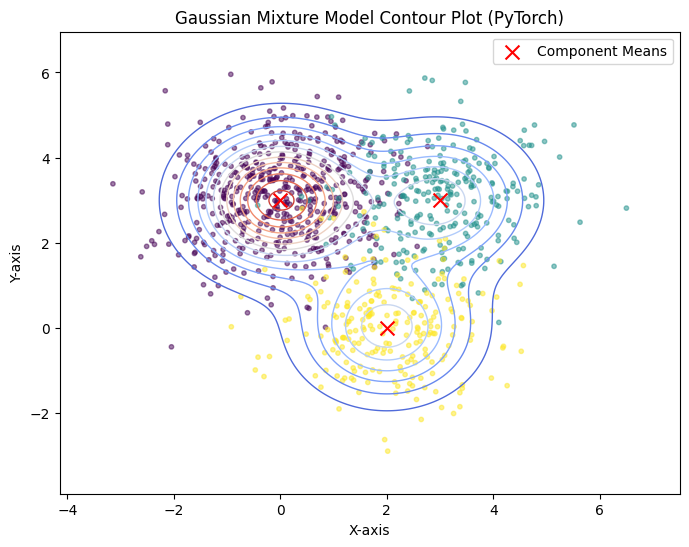

In [7]:
plot_gmm_contours(data, means, covariances, weights, labels)

In [33]:
class SimpleMLP(torch.nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, time_dim=128, T=300,
                 beta_start = 1e-4, beta_end = 0.02):
        super().__init__()

        self.T = T
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, T)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        self.time_emb = torch.nn.Sequential(
            torch.nn.Linear(1, time_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(time_dim, time_dim),
            torch.nn.ReLU()
        )
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim + time_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim)  # Predicts noise for each dimension
        )

        self.loss = torch.nn.MSELoss()
    
    def forward(self, x, t):
        # x: [batch_size, 2]
        # t: [batch_size]
        t = t.unsqueeze(1).float() / self.T  # Normalize timestep
        time_embedding = self.time_emb(t)  # [batch_size, time_dim]
        x = torch.cat([x, time_embedding], dim=1)  # [batch_size, 2 + time_dim]
        return self.net(x)  # [batch_size, 2]


    def q_sample(self, x_start, t, noise=None):
        """Sample from q(x_t | x_0)"""
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alphas_cumprod_t = self.alphas_cumprod[t].sqrt().unsqueeze(1)
        sqrt_one_minus_alphas_cumprod_t = (1 - self.alphas_cumprod[t]).sqrt().unsqueeze(1)
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    @torch.inference_mode()
    def sample(self, shape):
        self.eval()
        x = torch.randn(shape)
        
        for t in reversed(range(self.T)):
            
            t_batch = torch.full((shape[0],), t, dtype=torch.long)
            epsilon = self(x, t_batch)
            alpha = self.alphas[t]
            alpha_cumprod = self.alphas_cumprod[t]
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * epsilon)
            x += self.beta_start ** 0.5 * noise  # Simplified noise scaling
        return x

In [54]:
model = SimpleMLP(T=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

In [55]:
losses = []

for epoch in tqdm(range(1000)):
    # zero out gradients
    optimizer.zero_grad()
    
    # sample a different t for each sample
    t = torch.randint(0, model.T, (len(data),))

    # sample q(x_t | x_0)
    noise = torch.randn_like(data)
    x_t = model.q_sample(data, t, noise)
    
    # predict noise from x_t
    epsilon_theta = model(x_t, t)

    # compute loss
    loss = model.loss(epsilon_theta, noise)
    loss.backward()
    losses.append(loss.item())

    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

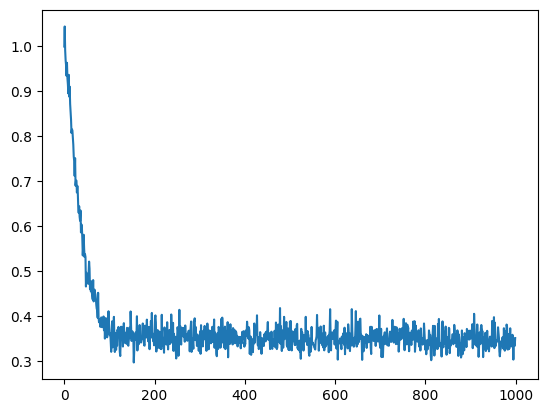

In [56]:
plt.plot(losses)

In [57]:
samples = model.sample((1000, 2))

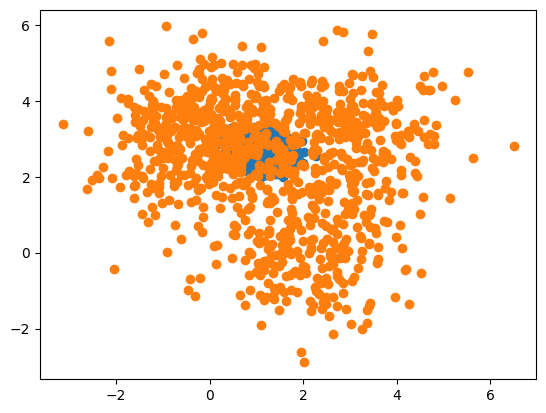

In [60]:
plt.scatter(samples[:, 0], samples[:, 1])
plt.scatter(data[:, 0], data[:, 1])

In [25]:
x_T = torch.randn_like(data)

In [ ]:
t_batch = torch.full((shape[0],), t, device=device, dtype=torch.long)

In [67]:
model.loss(epsilon_theta, noise)

tensor(1.0022, grad_fn=<MseLossBackward0>)

In [58]:
epsilon_theta - noise

tensor([[-0.5791,  0.2258],
        [ 0.4468,  1.4318],
        [ 0.1508,  1.3279],
        ...,
        [-0.1624,  0.8694],
        [ 0.1676, -0.2470],
        [-0.1156,  0.5451]], grad_fn=<SubBackward0>)

In [42]:
model.q_sample(data, t)

tensor([[ 0.5609,  0.9956],
        [ 0.3039,  0.1791],
        [ 0.4807,  3.2926],
        ...,
        [ 0.3344, -0.7122],
        [ 0.8890, -0.7150],
        [ 1.7530,  0.0465]])

In [31]:
model(data, t)

tensor([[ 0.0718, -0.0569],
        [ 0.0607, -0.0505],
        [ 0.0854, -0.0517],
        ...,
        [ 0.0369, -0.0368],
        [ 0.0561, -0.0295],
        [ 0.0443, -0.0342]], grad_fn=<AddmmBackward0>)

In [33]:
noise = torch.randn_like(data)

In [36]:
xt = q_sample(data, t, noise)

NameError: name 'q_sample' is not defined

In [ ]:
q_sample